In [1]:
from importlib.metadata import version
import nltk
nltk.download('stopwords')
import tensorflow as tf
from nltk.corpus import stopwords
import requests
import os
import re
import tensorflow
import summa
from summa.summarizer import summarize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, AdditiveAttention, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import urllib.request
from bs4 import BeautifulSoup 
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


3.6.5
2.6.0
1.3.3
1.2.0


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [126]:
data.sample(10)

,headlines,text
71547,Not even a dog knows you: Ssharad on people wh...,"Actor Ssharad Malhotra, while talking about pe..."
60337,Aussie coach Tom Moody mistaken for rating age...,Several CPM supporters began trolling and dire...
47504,ChaKu stabbed SA brutally: Sehwag on spinners'...,Reacting to Indian spinners Kuldeep Yadav and ...
76214,Chinese tourist assaulted by US border guard a...,A Chinese woman has been awarded Ã¢ÂÂ¹2.9 cro...
45744,Telangana students found mass copying may face...,Students found mass copying in Telangana class...
89207,Modi is illegal not the red beacon on my car: ...,Reiterating that he will not remove the red be...
71301,Player falls off chair while swatting a fly at...,USA's Sloane Stephens fell off a chair while t...
69545,Ex-White House Press Secretary mocks Trump ove...,Former White House Press Secretary made a surp...
13694,Eng cricketers' vehicle gets stuck in mud on a...,The vehicle carrying a few England cricketers ...
15772,Jet Airways delays part of Aug salaries to pil...,"Cash-strapped Jet Airways has told its pilots,..."


### 데이터 전처리하기(추상적 요약)

In [127]:
len(data['text'])

98401

In [128]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [129]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [130]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [131]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [132]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [133]:
# # 데이터 전처리 함수
# def preprocess_sentence(sentence, remove_stopwords=True):
#     sentence = sentence.lower() # 텍스트 소문자화
#     sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
#     sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
#     sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
#     sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
#     sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
#     sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
#     sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
#     # 불용어 제거 (Text)
#     if remove_stopwords:
#         tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
#     # 불용어 미제거 (Summary)
#     else:
#         tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
#     return tokens
# print('=3')

In [134]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()  # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text  # HTML 문법 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)  # 괄호 안에 문자열 제거
    sentence = re.sub('"', '', sentence)  # 쌍따옴표 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])  # 약어 정규화
    sentence = re.sub(r"'s\b", "", sentence)  # 소유격 제거
    sentence = re.sub("[^a-zA-Z]", " ", sentence)  # 영어 외 문자 제거
    sentence = re.sub('[m]{2,}', 'mm', sentence)  # m이 3개 이상이면 2개로 변경
    sentence = re.sub('\s+', ' ', sentence).strip()  # 연속된 공백 제거
    sentence = ' '.join([word for word in sentence.split() if len(word) <= 20])  # 단어 길이 제한
    sentence = re.sub(r'\b(\w+)( \1\b)+', r'\1', sentence)  # 중복 단어 제거
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

* EX)

In [135]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.. Father. fffffffffffffffffffffffff'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
제목의 최소 길이 : 1
제목의 최대 길이 : 18
제목의 평균 길이 : 9.553660024400163


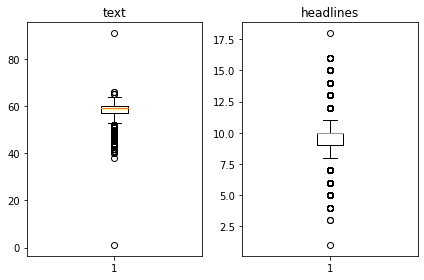

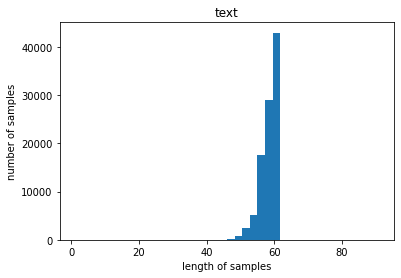

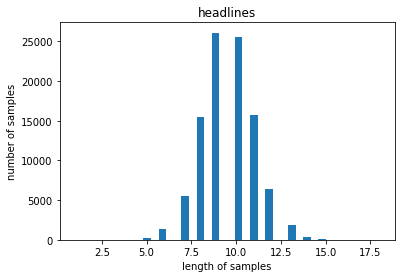

In [136]:
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('제목의 최소 길이 : {}'.format(np.min(summary_len)))
print('제목의 최대 길이 : {}'.format(np.max(summary_len)))
print('제목의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [137]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
clean_text = []

# [[YOUR CODE]]

clean_text = data['text'].apply(lambda x: preprocess_sentence(x) if pd.notnull(x) else "")


# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  0    saurav kant alumnus upgrad iiit pg program mac...
1    kunal shah credit card bill payment platform c...
2    new zealand defeated india wickets fourth odi ...
3    aegon life iterm insurance plan customers enjo...
4    speaking sexual harassment allegations rajkuma...
Name: text, dtype: object


In [138]:
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
clean_headlines = []

# [[YOUR CODE]]

clean_headlines = data['headlines'].apply(lambda x: preprocess_sentence(x,remove_stopwords=False) if pd.notnull(x) else "")
print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  0    upgrad learner switches to career in ml al wit...
1    delhi techie wins free food from swiggy for on...
2    new zealand end rohit sharma led india match w...
3    aegon life iterm insurance plan helps customer...
4    have known hirani for yrs what if metoo claims...
Name: headlines, dtype: object


In [139]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [140]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [141]:
text_max_len = 50
summary_max_len = 12

In [142]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [143]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9881150874339162


In [144]:
# 굳이 할 필요 없을 것 같긴한데...
# text 열에서 단어 시퀀스 길이 제한
data['text'] = data['text'].apply(lambda s: ' '.join(s.split()[:text_max_len]) if pd.notnull(s) else s)

# headlines 열에서 단어 시퀀스 길이 제한
data['headlines'] = data['headlines'].apply(lambda s: ' '.join(s.split()[:summary_max_len]) if pd.notnull(s) else s)

In [145]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [146]:
# 제목에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [147]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [148]:
# 셔플 
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[41129 83074 46320 ... 78006 92386 90138]


In [149]:
# 동일하게 
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [150]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


In [237]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


### 인코더 

In [238]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [239]:
len(encoder_input_train)

78688

In [240]:
import math

In [243]:
threshold = 6
total_cnt = len(src_tokenizer.word_index)  # 단어 집합 크기
rare_cnt = 0  # 등장 빈도수가 threshold보다 작은 단어 개수
total_freq = 0  # 전체 단어 빈도수 총합
rare_freq = 0  # 희귀 단어 빈도수 총합

# 전체 문서 수 (예: 샘플 수)
total_documents = len(encoder_input_train)
# 결과 저장용 리스트
freq_inverse_freq_data = []

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    # 전체 빈도수 합계
    total_freq += value

    # 희귀 단어 체크
    if value < threshold:
        rare_cnt += 1
        rare_freq += value

    # 빈도-역빈도 계산 (TF와 IDF 추가)
    tf = value / total_freq  # Term Frequency (TF)
    idf = math.log((total_documents + 1) / (value + 1))  # Inverse Document Frequency (IDF)
    tf_idf = tf * idf  # TF-IDF 계산

    # 빈도, 역빈도, TF-IDF 데이터 저장
    inverse_frequency = 1 / value
    freq_inverse_ratio = value * inverse_frequency
    freq_inverse_freq_data.append((key, value, inverse_frequency, freq_inverse_ratio, tf, idf, tf_idf))

# 결과 출력
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' % (threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 : %s' % (total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율 :", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :", (rare_freq / total_freq) * 100)

# 빈도-역빈도 데이터프레임 생성
import pandas as pd
freq_df = pd.DataFrame(freq_inverse_freq_data, columns=[
    "word", "frequency", "inverse_frequency", "freq_inverse_ratio", "TF", "IDF", "TF-IDF"
])

# 상위 몇 개 단어를 출력
print(freq_df.head())

단어 집합(vocabulary)의 크기 : 69782
등장 빈도가 5번 이하인 희귀 단어의 수: 45803
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 : 23979
단어 집합에서 희귀 단어의 비율 : 65.63727035625233
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 3.1020956817483905
         word  frequency  inverse_frequency  freq_inverse_ratio        TF  \
0  government       8915           0.000112                 1.0  1.000000   
1      monday       3673           0.000272                 1.0  0.291786   
2     imposed        564           0.001773                 1.0  0.042883   
3      import        114           0.008772                 1.0  0.008593   
4        duty        382           0.002618                 1.0  0.027989   

        IDF    TF-IDF  
0  2.177656  2.177656  
1  3.064222  0.894097  
2  4.936433  0.211690  
3  6.528327  0.056100  
4  5.325224  0.149050  


In [210]:
freq_df['TF-IDF'].mean()

0.00032806689789110225

In [244]:
src_vocab = 10000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [245]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[8, 60, 897, 3958, 1365, 30, 1788, 1275, 5763, 2135, 3054, 1036, 2474, 5763, 1170, 1414, 3158, 4732, 163, 289, 33, 1138, 8, 293, 3958, 1365, 592, 1414], [24, 2792, 744, 87, 24, 1935, 71, 160, 111, 441, 130, 95, 757, 71, 2413, 2212, 107, 2243, 1637, 130, 692, 1889, 71, 2212, 2413, 107, 76, 904, 130, 4252, 71], [196, 2648, 14, 1227, 3159, 6984, 4253, 1943, 9177, 815, 1289, 1801, 2633, 2920, 187, 171, 1638, 584, 4, 815, 8428, 1289, 4057, 3160, 101, 55, 80, 2576]]


### 디코더 (타겟) 

In [246]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [247]:
threshold = 7
total_cnt = len(tar_tokenizer.word_index)  # 단어 집합 크기
rare_cnt = 0  # 등장 빈도수가 threshold보다 작은 단어 개수
total_freq = 0  # 전체 단어 빈도수 총합
rare_freq = 0  # 희귀 단어 빈도수 총합

# 전체 문서 수 (예: 샘플 수)
total_documents = len(decoder_input_train)
# 결과 저장용 리스트
freq_inverse_freq_data = []

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    # 전체 빈도수 합계
    total_freq += value

    # 희귀 단어 체크
    if value < threshold:
        rare_cnt += 1
        rare_freq += value

    # 빈도-역빈도 계산 (TF와 IDF 추가)
    tf = value / total_freq  # Term Frequency (TF)
    idf = math.log((total_documents + 1) / (value + 1))  # Inverse Document Frequency (IDF)
    tf_idf = tf * idf  # TF-IDF 계산

    # 빈도, 역빈도, TF-IDF 데이터 저장
    inverse_frequency = 1 / value
    freq_inverse_ratio = value * inverse_frequency
    freq_inverse_freq_data.append((key, value, inverse_frequency, freq_inverse_ratio, tf, idf, tf_idf))

# 결과 출력
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' % (threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 : %s' % (total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율 :", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :", (rare_freq / total_freq) * 100)

# 빈도-역빈도 데이터프레임 생성
import pandas as pd
freq_df = pd.DataFrame(freq_inverse_freq_data, columns=[
    "word", "frequency", "inverse_frequency", "freq_inverse_ratio", "TF", "IDF", "TF-IDF"
])

# 상위 몇 개 단어를 출력
print(freq_df.head()) 

단어 집합(vocabulary)의 크기 : 30212
등장 빈도가 6번 이하인 희귀 단어의 수: 20709
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 : 9503
단어 집합에서 희귀 단어의 비율 : 68.54561101549054
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 5.349849686517276
       word  frequency  inverse_frequency  freq_inverse_ratio        TF  \
0  sostoken      78688           0.000013                 1.0  1.000000   
1      govt       2182           0.000458                 1.0  0.026982   
2   imposes         52           0.019231                 1.0  0.000643   
3       tax        298           0.003356                 1.0  0.003669   
4        on      10154           0.000098                 1.0  0.111126   

        IDF    TF-IDF  
0  0.000000  0.000000  
1  3.584803  0.096724  
2  7.302967  0.004693  
3  5.572815  0.020447  
4  2.047537  0.227534  


In [219]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 24, 2230, 342, 7, 3261, 6, 2441, 1639], [1, 161, 1435, 194, 4835, 158, 3333], [1, 4249, 151, 250, 1407, 3, 6849, 2961, 754], [1, 379, 820, 6, 1923, 3, 5218, 58, 47, 1811], [1, 3899, 176, 3678, 95, 3, 21, 353, 924, 6479]]
target
decoder  [[24, 2230, 342, 7, 3261, 6, 2441, 1639, 2], [161, 1435, 194, 4835, 158, 3333, 2], [4249, 151, 250, 1407, 3, 6849, 2961, 754, 2], [379, 820, 6, 1923, 3, 5218, 58, 47, 1811, 2], [3899, 176, 3678, 95, 3, 21, 353, 924, 6479, 2]]


In [220]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78687
훈련 레이블의 개수 : 78687
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [221]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

### 어텐션 메커니즘 사용하기(추상적 요약)

* layer와 텐서 라이브러리가 위 과정 어딘가에서 더럽혀지는 현상이 확인되었다.
* 재정의를 해주니까 에러없이 진행

In [222]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, LayerNormalization, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [223]:
# Positional Encoding 

def positional_encoding(max_position, d_model):
    positions = np.arange(max_position)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pos_encoding = np.zeros((max_position, d_model))
    pos_encoding[:, 0::2] = np.sin(positions * div_term)
    pos_encoding[:, 1::2] = np.cos(positions * div_term)
    return tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)

#어텐션 블록
def scaled_dot_product_attention(q, k, v, mask=None):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

# 멀티헤드 
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        self.dense = Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask=None):
        batch_size = tf.shape(q)[0]
        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)
        scaled_attention, _ = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        return output

# ffn
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        Dense(dff, activation='relu'),
        Dense(d_model)
    ])

# 트랜스포머 
class TransformerLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, name=None):
        super(TransformerLayer, self).__init__(name=name)  # 이름을 부모 클래스에 전달
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, x, mask=None):
        attn_output = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2


# 함수 
def build_transformer_model(text_vocab_size, summary_vocab_size, text_max_len, summary_max_len, d_model=128, num_heads=4, dff=512, num_layers=4, dropout_rate=0.1):
    # Encoder
    encoder_inputs = Input(shape=(text_max_len,), name="encoder_inputs")
    encoder_embedding = Embedding(text_vocab_size, d_model)(encoder_inputs)
    encoder_pos_encoding = positional_encoding(text_max_len, d_model)
    encoder_output = encoder_embedding + encoder_pos_encoding

    for i in range(num_layers):
        encoder_output = TransformerLayer(d_model, num_heads, dff, dropout_rate, name=f"encoder_layer_{i}")(encoder_output)

    # Decoder
    decoder_inputs = Input(shape=(summary_max_len,), name="decoder_inputs")
    decoder_embedding = Embedding(summary_vocab_size, d_model)(decoder_inputs)
    decoder_pos_encoding = positional_encoding(summary_max_len, d_model)
    decoder_output = decoder_embedding + decoder_pos_encoding

    for i in range(num_layers):
        # 디코더는 인코더 출력를 받게끔
        decoder_output = TransformerLayer(d_model, num_heads, dff, dropout_rate, name=f"decoder_layer_{i}")(decoder_output)
        attention_output = MultiHeadAttention(d_model, num_heads)(decoder_output, encoder_output, encoder_output)
        decoder_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(decoder_output + attention_output)

    # 최종
    final_output = Dense(summary_vocab_size, activation='softmax', name="final_dense")(decoder_output)

    return Model(inputs=[encoder_inputs, decoder_inputs], outputs=final_output)

In [225]:
from tensorflow.keras.optimizers import Adam

# 모델 
text_vocab_size = 15000  
summary_vocab_size = 8000  
text_max_len = 50
summary_max_len = 12
d_model = 128  # 임베딩 차원
num_heads = 4  # 멀티헤드 어텐션의 헤드 수
dff = 512  # FFN의 차원
num_layers = 4  # 트랜스포머 레이어
dropout_rate = 0.1

# 모델 빌드
model = build_transformer_model(
    text_vocab_size=text_vocab_size,
    summary_vocab_size=summary_vocab_size,
    text_max_len=text_max_len,
    summary_max_len=summary_max_len,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    num_layers=num_layers,
    dropout_rate=dropout_rate
)

In [226]:
# 모델 구조 
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 50, 128)      1920000     encoder_inputs[0][0]             
__________________________________________________________________________________________________
tf.__operators__.add_34 (TFOpLa (None, 50, 128)      0           embedding_10[0][0]               
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 12)]         0                                            
___________________________________________________________________________________________

In [227]:
# 모델 컴파일
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

### accuracy는 괜히 넣은듯 싶다
* 과적합까지 굉장히 오래 걸릴 듯 싶다.

In [228]:
# 가중치 저장 콜백
checkpoint = ModelCheckpoint(
    filepath='best_transformer_weights.h5',  
    monitor='val_loss', 
    save_best_only=True, 
    save_weights_only=True, 
    verbose=1
)

# 학습 실행
history = model.fit(
    [encoder_input_train, decoder_input_train], 
    decoder_target_train,  
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), 
    epochs=5, 
    batch_size=64,
    callbacks=[checkpoint]
)

Epoch 1/5
1230/1230 [==============================] - 79s 56ms/step - loss: 6.2053 - accuracy: 0.2038 - val_loss: 6.1197 - val_accuracy: 0.2071

Epoch 00001: val_loss improved from inf to 6.11969, saving model to best_transformer_weights.h5
Epoch 2/5
1230/1230 [==============================] - 67s 55ms/step - loss: 6.1561 - accuracy: 0.2040 - val_loss: 6.1154 - val_accuracy: 0.2071

Epoch 00002: val_loss improved from 6.11969 to 6.11545, saving model to best_transformer_weights.h5
Epoch 3/5
1230/1230 [==============================] - 68s 55ms/step - loss: 6.1514 - accuracy: 0.2040 - val_loss: 6.1101 - val_accuracy: 0.2071

Epoch 00003: val_loss improved from 6.11545 to 6.11012, saving model to best_transformer_weights.h5
Epoch 4/5
1230/1230 [==============================] - 67s 55ms/step - loss: 6.1488 - accuracy: 0.2040 - val_loss: 6.1096 - val_accuracy: 0.2071

Epoch 00004: val_loss improved from 6.11012 to 6.10957, saving model to best_transformer_weights.h5
Epoch 5/5
1230/1230 

## 과적합까지 시간이 없어 도달하지 못했지만, loss는 꾸준히 감소한다.

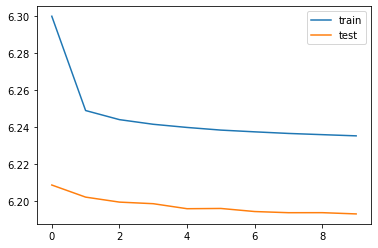

In [172]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [173]:
# 저장된 가중치 로드
model.load_weights('best_transformer_weights.h5')

### 실제 결과와 요약문 비교하기(추상적 요약)

In [230]:
# 주요 변수 확인 및 매핑
src_index_to_word = src_tokenizer.index_word  # 원문 단어 집합에서 정수 -> 단어
tar_word_to_index = tar_tokenizer.word_index  # 요약 단어 집합에서 단어 -> 정수
tar_index_to_word = tar_tokenizer.index_word  # 요약 단어 집합에서 정수 -> 단어

In [231]:
from tensorflow.keras.models import Model

encoder_model = Model(
    inputs=model.input[0],  
    outputs=model.get_layer("encoder_layer_3").output  
)

In [233]:
from tensorflow.keras.layers import LayerNormalization

decoder_inputs = Input(shape=(1,), name="decoder_inputs_test")  # 단어 단위 
decoder_embedding = model.get_layer("embedding_11")(decoder_inputs)  # 디코더 임베딩 
decoder_pos_encoding = positional_encoding(1, d_model)  # 포지셔널 
decoder_outputs = decoder_embedding + decoder_pos_encoding

encoder_outputs = Input(shape=(text_max_len, d_model), name="encoder_outputs_test")

for i in range(4):  
    decoder_layer = model.get_layer(f"decoder_layer_{i}")
    mha_layer = model.get_layer(f"multi_head_attention_{45 + i * 2}")  # 정확한 레이어 이름 매핑
    decoder_outputs = decoder_layer(decoder_outputs)
    attention_output = mha_layer(decoder_outputs, encoder_outputs, encoder_outputs)
    decoder_outputs = LayerNormalization(epsilon=1e-6)(decoder_outputs + attention_output)

final_output = model.get_layer("final_dense")(decoder_outputs)

decoder_model = Model(inputs=[decoder_inputs, encoder_outputs], outputs=final_output)

In [234]:
def decode_sequence(input_seq):
    
    encoder_output = encoder_model.predict(input_seq)

   
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        
        output_tokens = decoder_model.predict([target_seq, encoder_output])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word.get(sampled_token_index, '<UNK>')

        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token

        
        if (sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (summary_max_len - 1)):
            stop_condition = True

       
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

    return decoded_sentence.strip()

In [196]:
decode_sequence(encoder_input_test)

ValueError: Data cardinality is ambiguous:
  x sizes: 1, 19672
Make sure all arrays contain the same number of samples.

### 인코더 디코더 분리에서 에러가 났다. 
 * 1) 학습이 덜 되어서 문제가 일어났다.
 * 2) 인코더 디코더 분리 함수 자체에 문제가 있다. 
    * 받아오는 레이어 층수에 충돌이 난 것

### Summa을 이용해서 추출적 요약해보기

In [3]:
pip install summa

Note: you may need to restart the kernel to use updated packages.


In [4]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [8]:
from summa import summarizer

# 첫번째행만
text_to_summarize = data['text'][0]  

# 요약
summary = summarizer.summarize(text_to_summarize, ratio=0.3,words=50)

# 요약이 비어있음?
if summary:
    print("headlines:")
    print(summary)
else:
    print("요약없음")

headlines:
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience.
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


In [9]:
# 첫번째행만
text_to_summarize = data['text'][0]  

# 요약
summary = summarizer.summarize(text_to_summarize, ratio=0.3,words=40)

# 요약이 비어있음?
if summary:
    print("headlines:")
    print(summary)
else:
    print("요약없음")

headlines:
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


* decoder 시퀀스 디버깅 후, 원문과 비교한 다음
* summa와 비교해볼것